<a href="https://colab.research.google.com/github/yvrjsharma/JAX/blob/main/JAX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stateless JAX, PyTreees, and Multi Layer Perceptron

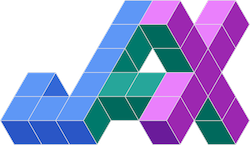

Goal of this notebook is to provide you the tools and understanding of JAX concepts, needed to construct a simple Neural Network. I will be borrowing some bits from the official JAX documentation. 

JAX follows the functional Programming Paradigm. As seen in my last post, JAX needs pure functions. JAX does not care about state, so you can't use stateful programming conepts like you do in Object Oriented Prograamming (OOP). JAX is stateless. I think I have covered **Pure Functions** in my last notebook, however I will just review the salient features very quickly anyway - A pure function would only compute or process the variables passed on to it as arguments. In other words, a pure function would have outputs which are based solely on its inputs and it has no side-effects. So how we usually do in OOP appproach, we cant do tha anymore. However, is there a way around it?

Lets talk more about Stateful and Stateless. I read a great example somewhere in my google search explaining difference between the two. Consider someone saying 'Good Morning' to you and then you responding 'Good Morning' to them. Now consider that same person saying 'Good Morning' to you again, now you might not respond to them and would certainly think what is wrong with them, they have said good morning to you already. You are being **Stateful**. A **Stateless** program would keep replying 'Good Morning' everytime it gets a 'Good morning' as a call, because it has no capability of capturing past inputs.

Also, before we go any further I would want you to recount that ```jax.jit``` impose constraints on the functions that it transforms. The function should not have any **side-effects** because if there are any side-effects, jit will *only execute them once* and that is during the time of compilation. I have touched upon this in a bit more detail in my previous notebook as well.


In [1]:
#Lets import the required libraries
import jax
import jax.numpy as jnp
import numpy as np

#transformation : higher order functions which take fuun as an input and outputs a transformed fun 
from jax import grad, jit, vmap, pmap
from jax import random

import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

* By now you must be well aware of the **limitations of JAX** when it comes to implementing ML/DL frameworks. Biggest limitations are -- JAX is *stateless*, it needs *pure functions* to operate with speed on, and that *side-effects* in functions are not taken care of while using jit.

* In ML OOP paradigm, like used in tensorflow and pytorch, program state is a very important feature as we use it to pass model parameters, optimizer states and details about NN layers.

* Changing program states -
    - Is one kind of a side-effect only
    - That is how OOP programs handle variables and parameters
    - Hope this below *stateful* program clears it for you  




In [2]:
#Program for a Counter
class Counter:

  def __init__(self):
    self.n=0

  def count(self) -> int:
    #Increments counter and returns incremented value
    self.n +=1
    return self.n
  
  def reset(self):
    #Reset the counter to zero
    self.n = 0

#initializing an object
counter = Counter()

#this gives the coount as expected
for _ in range(3):
  print(counter.count())

1
2
3


If I jit this function, or generally saying if I jit a stateful function, to make a function faster, it won't give me the desired results. The results are shown below.

This is happening because following line is only callled once ``` self.n+=1 ```

JAX compiles the function once and any subsequent call happens from the function compiled once and sitting in **XLA**. So it will always return the stored value, which is 1 in this case.



In [3]:
#setting the value  of count to 0
counter.reset()
#jit the counter function
faster_count = jax.jit(counter.count)

for _ in range(3):
  print(faster_count()) #It will print all 1s because of side-effects in the couter function

1
1
1


### How to make stateful programs work in JAX
In order to make this program work for JAX, we need to make some modifications -
* We need to pass the state *or the intial value of the counter variable* in the function call
* Please see below modifications to make it stateless or pure - 


In [3]:
CounterState = int 

class CounterV2:
  def count(self,n:CounterState) -> Tuple[int, CounterState]:
    #Returning n+1 twice, once as a state,
    #other as a counter. You might want to avoid it if confusing
    return n+1, n+1
  def reset(self) -> CounterState:
    #For setting the cunter value to 0
    return 0
  
#initializing an object
counter = CounterV2()
#Assigning initial value
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  #seems like we are now able to pass the state to the pure function and thus avoiding any side-effects 
  #output depends on inputs now
  print(value) #Will print 1,2,3 as was expected initially

1
2
3


If I use ```jax.jit``` on this function now, I will get the same *stateful result* but faster.

In [5]:
#Assigning initial value
state = counter.reset()
faster_count2 = jax.jit(counter.count)

for _ in range(3):
  value, state = faster_count2(state)
  #seems like e are now able to pass the state to the function and thus making it pure 
  #output depends on inputs now
  print(value) #Will print 1,2,3 as was expected initially even after we jit it

1
2
3


So, the general strategy of creating / using classes in JAX should be as follows -

Take a *stateful* class (like how it is usually represented in pytorch/tensorflow)

```
class StatefulClass:
  state: State
  def stateful_function(*args, **kwargs) -> output:
    function definintion

```

And convert it to *stateless* by passing state inside the function arguments -

```
class StatelessClass:
  def stateless_function(state:State, *args, **kwargs) -> output:
    function defn
```

**This is nice, we have taken our first step in implementing neural networks in JAX by understanding how we have to handle program states differently in JAX, while also taking care that there are no side-effects**

### Lets understand **PyTrees**
**Pytree** is a solution from JAX for how to find gradients of nested datastructures which can be arbritrarily large and nested. 
Using PyTree you can design custom Neural Layers and train an end-to-end Neural network in JAX.

* It refers to a data-structure which is tree-like and is built out of Python objects.
* Various entries are called leaves.
* A pytree itself can be a leaf inside another pytree.
* JAX transformations like vmap, pmap, jit *etc.* can be easily and effectively called upon functions which take pytrees as inputs or produce them as outputs.


In [12]:
#Examples
pytree1 = [1,'a', counter] #3 leaves
pytree2 = (1,(2,3),())  #3 leaves
pytree3 = [1,{"k1":2,"k2":(3,4)},5]  #5 leaves

#To view the pytree structure of a tree
from jax.tree_util import tree_structure
print(tree_structure(pytree3))

#How to view and count the number of leaves in a pytree
leaves = jax.tree_leaves(pytree3)
print(f"{repr(pytree3)} has {len(leaves)} leaves, which are: {leaves}")

PyTreeDef([*, {'k1': *, 'k2': (*, *)}, *])
[1, {'k1': 2, 'k2': (3, 4)}, 5] has 5 leaves, which are: [1, 2, 3, 4, 5]


#### Why do we need PyTrees

Pytrees can become very useful when we are working in bulk with datasets, for example, list of lists or lists of dictionaries *etc.*

Where you can find uses of PyTrees?
* Model Params
* Dataset entries (*e.g.*, dictionaries)

#### Manipulating PyTrees
Most common functions include ``` jax.tree_map ``` and ``` jax.tree_multimap ```. Functioning wise they are similar to python map function.

In [17]:
#tree_map just like map(function, iterable) in python
list_of_lists= [[1,2,3],[1,2],[1,2,3,4]]
print(jax.tree_map(lambda x:x**2 , list_of_lists))

#tree_multimap
list_of_lists2 = [[2,2,2],[2,2],[2,2,2,2]]   #structure of two trees should exactly match
print(jax.tree_multimap(lambda x,y:x+y, list_of_lists, list_of_lists2))

[[1, 4, 9], [1, 4], [1, 4, 9, 16]]
[[3, 4, 5], [3, 4], [3, 4, 5, 6]]


**This is great, now we know how to handle State, how to handle parameters using pyTrees, and we have already discussed how we can take gradients in my previous notebook. Lets start building a very simple, elementary Neural Network in JAX.**

### Training a Multi-Layer Perceptron (MLP) or a simple neural network
* Defining an MLP


In [27]:
#Simple MLP which returns a pytree object as network parameters 
def init_mlp_params(layer_widths):
  params=[]

  #Setting weigths and biases
  for n_in,n_out in zip(layer_widths[:-1],layer_widths[1:]):
    params.append(dict(weights=np.random.normal(size=(n_in,n_out))*np.sqrt(2/n_in),biases=np.ones(shape=(n_out,))))

  return params  #a pytree

#Definining an MLP with single input(1), two hidden layers(128,128), and 1 output(1)
#3 layer MLP
params = init_mlp_params([1,128,128,1])

#Lest use the tree_map function to understand shapes in the params pytree
jax.tree_map(lambda x:x.shape,params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

* Training an MLP

In [49]:
#Define loss and update function
#Prediction or forward pass
def forward(params,x):
  *hidden, last = params
  
  for layer in hidden:
    x = jax.nn.relu(jnp.dot(x,layer['weights'])+layer['biases'])

  #last layer will just return raw wx+b results
  return jnp.dot(x, last['weights']) + last['biases'] 


#Lets keep our Loss function as simple Mean Square Error loss
def loss_fn(params,x,y):
  #Make prediction, find the error term 
  return jnp.mean((forward(params,x)-y)**2)

lr = 0.0001 #learning rate

@jit 
#gradient decent
def update(params,x,y):

  #Notice, how grad is gonna be operating on PyTree Params
  #grad will have same structure as Params 
  #Here we are calculating the gradient of the loss function
  grads = jax.grad(loss_fn)(params,x,y)

  return jax.tree_multimap(lambda p,g: p - lr*g, params, grads)

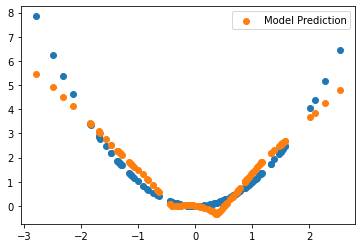

In [52]:
#Lets plot the target function and prediction
xs = np.random.normal(size=(128,1))
ys = xs**2

#Let it run for 1000 epochs in this sample case
for _ in range(1000):
  params = update(params,xs,ys) #see how we have used state/ how we have passed state as a parameter 

plt.scatter(xs, ys)
plt.scatter(xs,forward(params,xs), label="Model Prediction")
plt.legend();

**So, we have now trained our first Neural Network in JAX**

Lets see what else we need to do to implement the more complex ones -- We have to understand how **Custom PyTrees** can be implemented.
* So far, we have only been considering pytrees of lists, tuples, and dicts, everything else is considered a leaf in itself.
* For creating more complex NNs, we would be needed to create several new layers, for example like in CNN layers.
* For JAX to process the layers using pytree operations, we need to understand how a complex pytree consiting of class obects can be made useful.
* In below code, we will look at such pytrees, how JAX treats each object as an individual leaves and don't parse inside it, and how JAX can solve this problem. 


In [4]:
class MyContainer:

  def __init__(self,name:str, a:int, b:int, c:int):
    self.name = name 
    self.a = a
    self.b = b
    self.c = c

#Creating two container objects for this class
container1 = MyContainer('Alice',1,2,3)
container2 = MyContainer('Bob',4,5,6)

#creating a pytree with two container objects
sample_pytree = [container1, container2]

#Counting number of leaves to understand leaf assignment
leaves = jax.tree_leaves(sample_pytree)
print(leaves, "Nuumber of leaves : ",len(leaves))  #just two leaves

[<__main__.MyContainer object at 0x7f0e4bf8f550>, <__main__.MyContainer object at 0x7f0e4bf8f510>] Nuumber of leaves :  2


In [ ]:
#Understanding futher how operations on such a tree will not be possible
#We expected this tree_map operation to increment the values for a,b,c
#as pytrees are container objects 
print(jax.tree_map(lambda x:x+1, sample_pytree))  #this will throw error !

* To solve this, we need to **register our container** with JAX by telling it how to *flatten* it and then *unflatten* it.
* We have to instruct JAX to treat a Python type as an internal pytree node.
* We need a **flattening function**,  which will take an object and return a value pair, with 
  * (1) an iterable object carrying the children (like a,b,c in our example) that are flattened. These children will be treated as leaves to be treated recursively by JAX later on. 
  * (2) some auxiliary or meta data to be stored in the tree definition 
* We also neeed an **unflattening function**, which will take the iterable object and auxiliary data as its two arguments. This function would return the object back.

In [8]:
#Lets see this in action
def flatten_MyContainer(container):
  flat_contents = [container.a, container.b, container.c]

  #sending name in as meta data or auxiliary data
  #aux data is usually the description of the tree structure  
  aux_data = container.name

  return flat_contents, aux_data

def unflatten_MyContainer(aux_data, flat_contents):
  return MyContainer(aux_data, *flat_contents)

#To Register a Custom PyTree node with JAX
jax.tree_util.register_pytree_node(MyContainer, flatten_MyContainer, unflatten_MyContainer)

#Now to again check the numb er of leaves andd their values
jax.tree_leaves(sample_pytree)  #Six leaves this time

[1, 2, 3, 4, 5, 6]

Great, with all this understood, we are now capable and ready to create custom Neural layers and can train our Neural networks end-to-end. To handle training large neural networks over vast amount of data, we would need multiple cores or accelerators for faster and better results. 

In my next post I will be talking about parallelism in JAX, we will create larger more complex neural networks, and hopefully even a Resnet, or god willing, a shiny new Transformer!
